**Our main goal:** To train a binary segmentation model that separates blood vessels from other parts of inner eye in a retinal image.

**Our task here are:**
Crop every RGB image and corresponding vessels mask into multiple patches. Generate two unified datasets with 128x128px and 256x256px sized patches.



**Data sets that are used**

Digital Retinal Images for Vessel Extraction (DRIVE) [link](
http://www.isi.uu.nl/Research/Databases/DRIVE/):
* Training set: 20 RGB (565x584 pixels) images + aperture masks + segmented regions (vessels or not)
* Test set: 20 RGB (565x584) retinal images + aperture masks (FOV masks) + 2 variants of segmented regions (vessels or not) 

Structured Analysis of the Retina (STARE) [link](https://cecas.clemson.edu/~ahoover/stare/)
* The whole data set: 20 RGB (700x605 pixels) retinal images + 2 variants of segmented regions (vessels or not) with apertures (FOV masks)

High-Resolution Fundus Image Database HRF [link](http://www5.cs.fau.de/research/data/fundus-images/)
* The whole data set: 45 RGB (3504x2336  pixels) retinal images + aperture masks (FOV masks) + segmented regions (vessels or not)


**Decissions made:** We will use the *DRIVE*'s test images as our test data and combine other images as our train data set.

P.S. we will not use the aperture masks (FOV masks) in our analysis

*We have already downloaded all the datasets and stored them in Google Drive Storage*

In [ ]:
#Imporint essential libraries
from PIL import Image
import tensorflow as tf
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import math
import os
from google.colab import drive
%matplotlib inline

In [ ]:
#Mounting Google Drive
drive.mount('/content/gdrive')

In [ ]:
os.chdir('/content/gdrive/MyDrive/VGTU/Kompiuterine_rega_medicinoje/ND_nr_1')
!ls initial_data

**1) Transforming the *Digital Retinal Images for Vessel Extraction (DRIVE)* data set**

Files' tree for the *DRIVE* dataset is:
```
DRIVE
  test/
    1st_manual/
      01_manual1.gif
      ...
    2nd_manual/
      01_manual2.gif
      ...
    images/
      01_test.tif
      ...
    mask/
      01_test_mask.gif
      ...  
  train/
    1st_manual/
      21_manual1.gif
      ...
    images/
      21_training.tif
      ...
    mask/
      21_training_mask.gif
      ...
```


Sneak peek at the data

In [ ]:
def sneak_peek(paths,pics_per_row=3,pic_size=3):

  num_files = len(paths)
  fig, ax = plt.subplots( math.ceil(num_files/pics_per_row) , min(num_files,pics_per_row), 
       figsize=(pics_per_row*pic_size,math.ceil(num_files/min(num_files,pics_per_row))*pic_size))
  
  for i, path in enumerate(paths):
    #Load a sample
    with Image.open(os.path.join(os.getcwd(),path)) as im:
      h,w = np.asarray(im).shape[:2]
      c = 3 if len(np.asarray(im).shape)==3 else 1

      #Plot the sample
      if math.ceil(num_files/pics_per_row) >1:
        ax[int(i/pics_per_row)][i%pics_per_row].set_axis_off()
        fig.add_axes(ax[int(i/pics_per_row)][i%pics_per_row])
        ax[int(i/pics_per_row)][i%pics_per_row].imshow(im)
        ax[int(i/pics_per_row)][i%pics_per_row].title.set_text("dims: "+str(h)
                                                        +"x"+str(w)+"x"+str(c))
      else:
        ax[i].set_axis_off()
        fig.add_axes(ax[i])
        ax[i].imshow(im)
        ax[i].title.set_text("dims: "+str(h)+"x"+str(w)+"x"+str(c))

We can see that retinal images are RGB but vessel mask and aperture mask are grayscale. We will not use the apperture masks in our further investigation.

In [ ]:
def sort_list(x):
  x.sort()
  return x

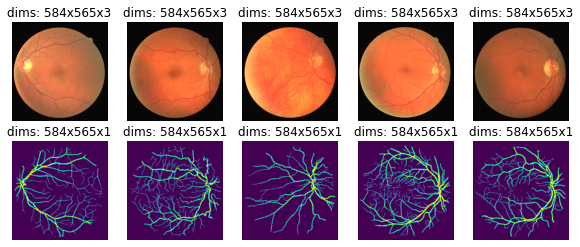

In [ ]:
folders = ['initial_data/DRIVE/training/images',
         'initial_data/DRIVE/training/1st_manual']

N_sampl = 5
paths = [ [os.path.join(folder,f_name) for f_name in sort_list(os.listdir(folder))[:N_sampl]] for folder in  folders]
paths = [item for sublist in paths for item in sublist]

sneak_peek(paths,pics_per_row=N_sampl,pic_size=2)

Defining the patch cropping function

In [ ]:
def crop_patch(img_path,N):
  '''
  img_path: path of an image
         N: side lenght of a cropped patch NxN
  '''
  with Image.open(img_path) as im:
    im = np.array(im)
  if len(im.shape)<3:
    im = np.expand_dims(im, axis=2)
  h, w = im.shape[:2]
  # Pad image with reflection
  # -> to make width and height a multiple of N
  w_new =  math.ceil(w/N)*N
  h_new =  math.ceil(h/N)*N
  paddings = tf.constant([[0, h_new-h,], [0, w_new-w],[0,0]]) # [[Up,Down],[Left,Right],[channels]]
  im_pad = tf.pad( im, paddings, "REFLECT") 
  patches = tf.expand_dims(im_pad[0:N, 0:N, : ],axis=0)
  for i in range( 0 , h_new , N ):
      for j in range( 0 , w_new , N ):
          if (i!=0) | (j!=0):
            patch = tf.expand_dims(im_pad[ i : i + N, j : j + N , : ],axis=0)
            patches = tf.concat( [patches,patch], axis=0 )
  return patches

Lets check out the cropped patch

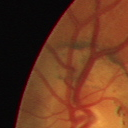

In [ ]:
img_path = 'initial_data/DRIVE/training/images/26_training.tif'
N = 128
cropps = crop_patch(img_path,N)

Image.fromarray(np.array(cropps[5]))

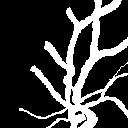

In [ ]:
img_path = 'initial_data/DRIVE/training/1st_manual/26_manual1.gif'
N = 128
cropps = crop_patch(img_path,N)

Image.fromarray(np.squeeze(np.array(cropps[5])))

Define a function that patches an image and stores every patch as a separate image

In [ ]:
def patch_and_save(init_path, final_path, N=128, extension='.png'):
  '''
   init_path : source path of the images to be patched and saves
   final_path: destination path of the cropped patches
   N         : side-lenght of the square patch
   extension : file extension
  '''
  if not os.path.exists(final_path):
    print('Creating a folder: ', final_path)
    os.mkdir(final_path)

  n_imgs = len(os.listdir(final_path)) #number of images already stored
  count = 0

  for file_name in tqdm(sort_list(os.listdir(init_path))):
    if os.path.isfile(os.path.join(init_path,file_name)):
      # Make patches
      patches = crop_patch(os.path.join(init_path,file_name),N)
      # Save patches as separate images
      for patch in patches:
        patch = np.array(patch)
        if patch.shape[-1] ==1:
          patch = np.squeeze(patch)
        patch = Image.fromarray(patch)
        patch_name = str(n_imgs+count) + extension
        count +=1
        try:
          patch.save(os.path.join(final_path,patch_name))
        except:
          print('Failed to save: ',os.path.join(final_path,patch_name))

Create folder to store generated patches

In [ ]:
# Create unified data folders
if not os.path.exists('unified_data'):
  os.mkdir('unified_data')
if not os.path.exists('unified_data/train'):
  os.mkdir('unified_data/train')
if not os.path.exists('unified_data/test'):
  os.mkdir('unified_data/test')

Patch the RGB images for training

In [ ]:
init_path = 'initial_data/DRIVE/training/images'
final_path_128 = 'unified_data/train/images_128px'

patch_and_save(init_path, final_path_128, N=128)

Creating a folder:  unified_data/train/images_128px


100%|██████████| 20/20 [00:15<00:00,  1.25it/s]


In [ ]:
final_path_256 = 'unified_data/train/images_256px'
patch_and_save(init_path, final_path_256, N=256)

Creating a folder:  unified_data/train/images_256px


100%|██████████| 20/20 [00:10<00:00,  1.96it/s]


and their corresponding segmentation masks

In [ ]:
init_path = 'initial_data/DRIVE/training/1st_manual'
final_path_128 = 'unified_data/train/vessels_masks_128px'

patch_and_save(init_path, final_path_128, N=128)

Creating a folder:  unified_data/train/vessels_masks_128px


100%|██████████| 20/20 [00:09<00:00,  2.12it/s]


In [ ]:
final_path_256 = 'unified_data/train/vessels_masks_256px'
patch_and_save(init_path, final_path_256 , N=256)

Creating a folder:  unified_data/train/vessels_masks_256px


100%|██████████| 20/20 [00:03<00:00,  6.38it/s]


Check the patches of the original images

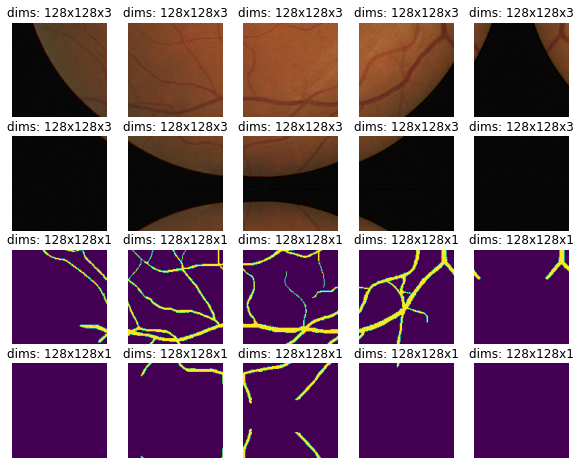

In [ ]:
folders = ['unified_data/train/images_128px',
         'unified_data/train/vessels_masks_128px']
 
N_sampl = 10
paths = [ [os.path.join(folder,f_name) for f_name in os.listdir(folder)[-N_sampl:]] for folder in  folders]
paths = [item for sublist in paths for item in sublist]

sneak_peek(paths,pics_per_row=N_sampl//2,pic_size=2)

We will not crop any patches from the test data and just relocate it to our final `unified_data/test` folder

In [ ]:
def relocate_imgs(init_path,final_path,extension = '.png'):
  if not os.path.exists(final_path):
    os.mkdir(final_path)

  count =0
  for f_name in tqdm(sort_list(os.listdir(init_path))):
    img_path = os.path.join(init_path,f_name)
    with Image.open(img_path) as im:
      im_name = str(count) + extension
      count +=1
      try:
        im.save(os.path.join(final_path,im_name))
      except:
        print('Failed to save: ',os.path.join(final_path,im_name))

In [ ]:
# Relocate RGB images from the test set
init_path = 'initial_data/DRIVE/test/images'
final_path = 'unified_data/test/images'

relocate_imgs(init_path,final_path)

100%|██████████| 20/20 [00:10<00:00,  1.88it/s]


In [ ]:
# Relocate segmentation masks from the test set
init_path = 'initial_data/DRIVE/test/1st_manual'
final_path = 'unified_data/test/vessels_masks'

relocate_imgs(init_path,final_path)

100%|██████████| 20/20 [00:05<00:00,  3.99it/s]


In [ ]:
!ls unified_data/test/images

0.png	11.png	13.png	15.png	17.png	19.png	2.png  4.png  6.png  8.png
10.png	12.png	14.png	16.png	18.png	1.png	3.png  5.png  7.png  9.png


**2) Transforming the *Structured Analysis of the Retina (STARE)* data set**

Files' tree for the *STARE* dataset is:
```
STARE
  labels-ah/
    im0001.ah.ppm
    ...
  labels-vk/
    im0001.vk.ppm
    ...
  stare-images/
    im0001.ppm
    ...
```
The `labels-ah/` and `labels-vk/` are folders with vessels' masks anotated by two different people. We will use images in the `labels-ah/` folder only.




Lets sneak peek at the data:

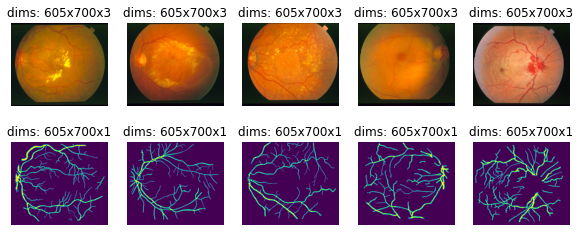

In [ ]:
folders = ['initial_data/STARE/stare-images',
         'initial_data/STARE/labels-ah']

N_sampl = 5
paths = [ [os.path.join(folder,f_name) for f_name in sort_list(os.listdir(folder))[:N_sampl]] for folder in  folders]
paths = [item for sublist in paths for item in sublist]

sneak_peek(paths,pics_per_row=N_sampl,pic_size=2)

Path the RGB images

In [ ]:
init_path = 'initial_data/STARE/stare-images'
final_path_128 = 'unified_data/train/images_128px'

patch_and_save(init_path, final_path_128, N=128)

100%|██████████| 20/20 [00:18<00:00,  1.10it/s]


In [ ]:
final_path_256 = 'unified_data/train/images_256px'
patch_and_save(init_path, final_path_256, N=256)

100%|██████████| 20/20 [00:11<00:00,  1.75it/s]


and their corresponding segmentation masks

In [ ]:
init_path = 'initial_data/STARE/labels-ah'
final_path_128 = 'unified_data/train/vessels_masks_128px'

patch_and_save(init_path, final_path_128, N=128)

100%|██████████| 20/20 [00:10<00:00,  1.86it/s]


In [ ]:
final_path_256 = 'unified_data/train/vessels_masks_256px'

patch_and_save(init_path, final_path_256, N=256)

100%|██████████| 20/20 [00:02<00:00,  6.74it/s]


Check the transfomed images

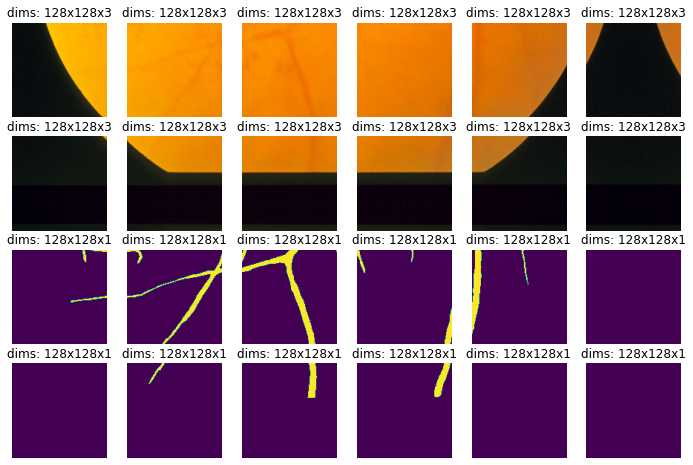

In [ ]:
folders = ['unified_data/train/images_128px',
         'unified_data/train/vessels_masks_128px']

N_sampl = 12
paths = [ [os.path.join(folder,f_name) for f_name in os.listdir(folder)[-N_sampl:]] for folder in  folders]
paths = [item for sublist in paths for item in sublist]

sneak_peek(paths,pics_per_row=N_sampl//2,pic_size=2)

**3) *High-Resolution Fundus Image Database (HRF)* data set**

Files tree for the *HRF* dataset is:
```
HRF
  images/
    01_dr.JPG
    ...
  manual1/
    01_dr.tif
    ...
  mask/
    01_dr_mask.tif
    ...
```

Lets sneak peek at the data:

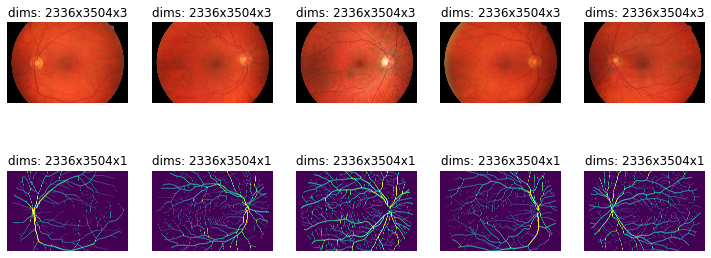

In [ ]:
folders = ['initial_data/HRF/images',
         'initial_data/HRF/manual1']

N_sampl = 5
paths = [ [os.path.join(folder,f_name) for f_name in sort_list(os.listdir(folder))[:N_sampl]] for folder in  folders]
paths = [item for sublist in paths for item in sublist]

sneak_peek(paths,pics_per_row=N_sampl,pic_size=2.5)

Here we can see, that the diameter of the FOV is arround 3000+px which is ~5 times bigger than our test data. **We will reduce the resolution of images 5 times before patching.**

In [ ]:
# Resize HRF RGB images
img_path = 'initial_data/HRF/images'
new_img_path = 'initial_data/HRF/images_small'

if not os.path.exists(new_img_path):
  os.mkdir(new_img_path)

for file in tqdm(os.listdir(img_path)):
  with Image.open(os.path.join(img_path,file)) as im:
    im = im.resize((im.size[0]//5,im.size[1]//5))
    im.save(os.path.join(new_img_path,file))

100%|██████████| 45/45 [00:29<00:00,  1.51it/s]


In [ ]:
# Resize HRF segmentation masks
mask_path = 'initial_data/HRF/manual1/'
new_mask_path = 'initial_data/HRF/manual1_small/'

if not os.path.exists(new_mask_path):
  os.mkdir(new_mask_path)

for file in tqdm(os.listdir(mask_path)):
  with Image.open(os.path.join(mask_path,file)) as im:
    im = im.resize((im.size[0]//5,im.size[1]//5))
    im.save(os.path.join(new_mask_path,file))

100%|██████████| 45/45 [00:20<00:00,  2.16it/s]


Lets check the scaled down version of HRF dataset

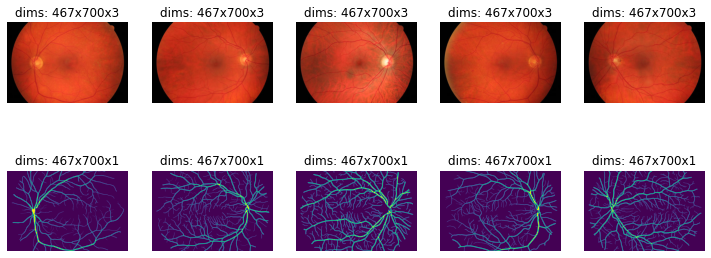

In [ ]:
folders = ['initial_data/HRF/images_small',
         'initial_data/HRF/manual1_small']

N_sampl = 5
paths = [ [os.path.join(folder,f_name) for f_name in sort_list(os.listdir(folder))[:N_sampl]] for folder in  folders]
paths = [item for sublist in paths for item in sublist]

sneak_peek(paths,pics_per_row=N_sampl,pic_size=2.5)

Extract patches from the RGB images

In [ ]:
init_path = 'initial_data/HRF/images_small'
final_path_128 = 'unified_data/train/images_128px'

patch_and_save(init_path, final_path_128, N=128)

100%|██████████| 45/45 [00:21<00:00,  2.12it/s]


In [ ]:
final_path_256 = 'unified_data/train/images_256px'
patch_and_save(init_path, final_path_256, N=256)

100%|██████████| 45/45 [00:11<00:00,  3.95it/s]


also patch the corresponding vessels' segmented masks

In [ ]:
init_path = 'initial_data/HRF/manual1_small/'
final_path_128 = 'unified_data/train/vessels_masks_128px'

patch_and_save(init_path, final_path_128, N=128)

100%|██████████| 45/45 [00:12<00:00,  3.62it/s]


In [ ]:
final_path_256 = 'unified_data/train/vessels_masks_256px'
patch_and_save(init_path, final_path_256, N=256)

100%|██████████| 45/45 [00:05<00:00,  8.72it/s]


Check the transfomed images

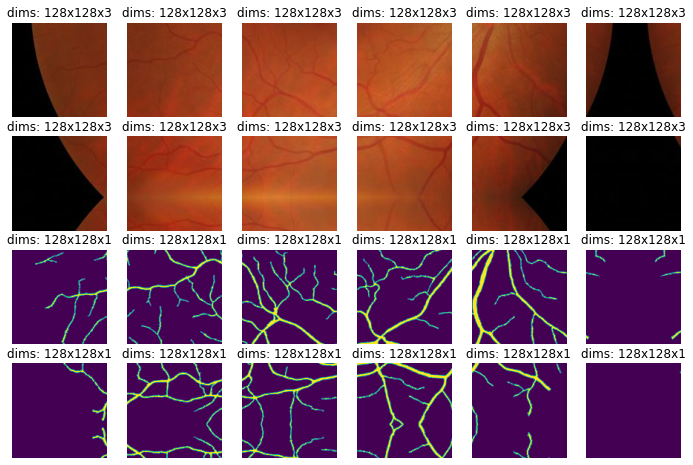

In [ ]:
folders = ['unified_data/train/images_128px',
         'unified_data/train/vessels_masks_128px']

N_sampl = 12
paths = [ [os.path.join(folder,f_name) for f_name in os.listdir(folder)[-N_sampl:]] for folder in  folders]
paths = [item for sublist in paths for item in sublist]

sneak_peek(paths,pics_per_row=N_sampl//2,pic_size=2)

**Conclusion:** Lets check the unified dataset

In [ ]:
print('Number of RGB 128x128 patches: ',len(os.listdir('unified_data/train/images_128px')))
print('Number of RGB 256x256 patches: ',len(os.listdir('unified_data/train/images_256px')))
print("Number of segmented masks' 128x128 patches: ",len(os.listdir('unified_data/train/vessels_masks_128px')))
print("Number of segmented masks' 256x256 patches: ",len(os.listdir('unified_data/train/vessels_masks_256px')))

Number of RGB 128x128 patches:  2180
Number of RGB 256x256 patches:  630
Number of segmented masks' 128x128 patches:  2180
Number of segmented masks' 256x256 patches:  630
